# **Figures: python plotting tips & tricks**
  James East & Drew Pendergrass  
  2024-02-22


# Get libraries

In [ ]:
!pip install basemap
!pip install pycno
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 14.9 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 79.2 MB/s eta 0:00:00


# Get toy data for plotting

In [ ]:
# EPA hourly O3 concentration data for plotting
!wget https://aqs.epa.gov/aqsweb/airdata/hourly_44201_2023.zip
!unzip hourly_44201_2023.zip

--2024-02-22 20:20:20--  https://aqs.epa.gov/aqsweb/airdata/hourly_44201_2023.zip
Resolving aqs.epa.gov (aqs.epa.gov)... 134.67.21.26, 2620:117:506f:15::f01a
Connecting to aqs.epa.gov (aqs.epa.gov)|134.67.21.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37759070 (36M) [application/zip]
Saving to: ‘hourly_44201_2023.zip’

hourly_44201_2023.z 100%[===================>]  36.01M   629KB/s    in 60s     

2024-02-22 20:21:21 (616 KB/s) - ‘hourly_44201_2023.zip’ saved [37759070/37759070]

Archive:  hourly_44201_2023.zip
  inflating: hourly_44201_2023.csv   


In [ ]:
!ls

GEOSChem.SpeciesConc.20190701_0000z.nc4  hourly_44201_2023.csv	hourly_44201_2023.zip  sample_data


In [ ]:
import pandas as pd
df = pd.read_csv('hourly_44201_2023.csv')

<ipython-input-4-79634485a728>:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('hourly_44201_2023.csv')


In [ ]:
# function for mda8 at a site
def get_site_mda8(site_num, state, county):

  dfsite = df[(df['Site Num'] == site_num) & (df['State Name'] == state) & (df['County Name'] == county)]
  dfsite = dfsite[['Latitude','Longitude','Date Local','Sample Measurement']]
  dfsite['Date Local'] = pd.to_datetime(dfsite['Date Local'])
  dfsite['Sample Measurement'] *= 1e3
  dfmda8 = dfsite.set_index('Date Local')
  # quick MDA8 calculation
  # not for regulatory enforcement :)
  dfmda8 = dfmda8.rolling('8H').mean().groupby(dfmda8.index.date).max()

  return dfmda8

In [ ]:
# pick a site
dfmda8 = get_site_mda8(10, 'Alabama','Baldwin')
dfmda8.head()

,Latitude,Longitude,Sample Measurement
2023-03-01,30.497478,-87.880258,25.000000
2023-03-02,30.497478,-87.880258,28.478261
2023-03-03,30.497478,-87.880258,46.000000
2023-03-04,30.497478,-87.880258,39.750000
2023-03-05,30.497478,-87.880258,37.166667


# Basic plotting

## 2 ways to make plots in matplotlib

In [ ]:
import matplotlib.pyplot as plt

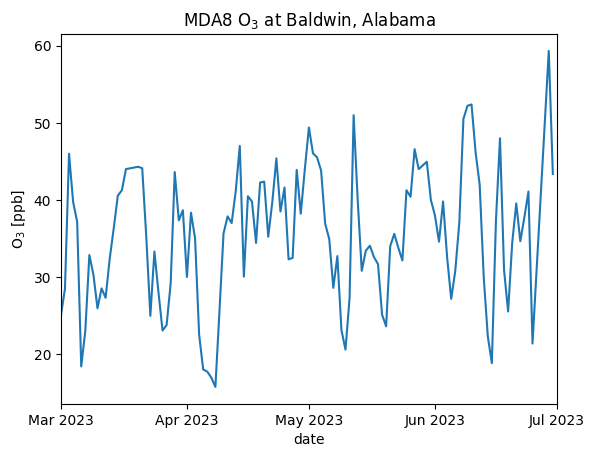

In [ ]:
# simple = often best way
plt.plot(
    dfmda8.index,
    dfmda8['Sample Measurement']
)
siteloc = f'{df.loc[0,"County Name"]}, {df.loc[0,"State Name"]}'
plt.title(f'MDA8 O$_3$ at {siteloc}')
plt.ylabel('O$_3$ [ppb]')
plt.xlabel('date')

xticks = pd.date_range('2023-01-01','2024-01-01',freq='MS')
xticklabels = xticks.strftime('%b %Y')

plt.xticks(xticks, labels=xticklabels)

plt.xlim(dfmda8.index.min(), dfmda8.index.max()+pd.Timedelta('1D'))

plt.show()

In [ ]:
# object oriented way
# more flexible if you want to make complicated plots
# for simple things, basically the same
fig, ax = plt.subplots()

ax.plot(
    dfmda8.index,
    dfmda8['Sample Measurement']
)
ax.set_title(f'MDA8 O$_3$ at {siteloc}')
ax.set_ylabel('O$_3$ [ppb]')
ax.set_xlabel('date')


ax.set_xticks(xticks, labels=xticklabels)

ax.set_xlim(dfmda8.index.min(), dfmda8.index.max()+pd.Timedelta('1D'))

plt.show()

## Multipanel plots
1. simplest = usually best way: Powerpoint!
2. python way = subplots

In [ ]:
# more names of sites
df_al = df.groupby(['State Name', 'County Name', 'Site Num']).first().reset_index()[['State Name','County Name', 'Site Num']].head(6)
df_al

,State Name,County Name,Site Num
0,Alabama,Baldwin,10
1,Alabama,DeKalb,9991
2,Alabama,Elmore,4
3,Alabama,Etowah,11
4,Alabama,Jefferson,23
5,Alabama,Jefferson,1003


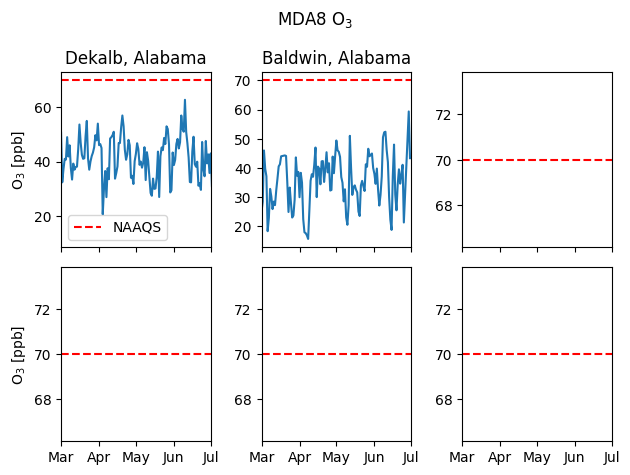

In [ ]:
# use object oriented approach for multi panel plots
fig, axs = plt.subplots(
    2, # n rows
    3, # n cols
    sharex = True, # optionally share x axis
    tight_layout=True # so things don't overlap
)

# access individual plots with axs[row, col]
axs[0,1].plot(
    dfmda8.index,
    dfmda8['Sample Measurement']
)
axs[0,1].set_title(siteloc) # individual title

fig.suptitle('MDA8 O$_3$') # big title



# try adding more data from sites above
df2 = get_site_mda8( 9991, 'Alabama', 'DeKalb')
siteloc = 'Dekalb, Alabama'
axs[0,0].plot(
    df2.index,
    df2['Sample Measurement']
)
axs[0,0].set_title(siteloc) # individual title

# y labels on edges
axs[0,0].set_ylabel('O$_3$ [ppb]')
axs[1,0].set_ylabel('O$_3$ [ppb]')

# add NAAQS line
naaqs = 70
for ax in axs.ravel():
  ax.axhline(70, color='r', ls='--', label = 'NAAQS')

axs[0,0].legend()

# x lim, only need 1
xticklabels = xticks.strftime('%b')
axs[0,1].set_xticks(xticks, labels=xticklabels, rotation=90)
axs[0,1].set_xlim(dfmda8.index.min(), dfmda8.index.max()+pd.Timedelta('1D'))

plt.show()


# Making Maps
3 options  
1. basemap
2. pycno
3. cartopy

## Let's make a basic plot of data on a map (basemap)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


In [ ]:
#Make example data!

lon_bounds = [126,127.6]
lat_bounds = [36.5,38.1]

lon = np.linspace(lon_bounds[0],lon_bounds[1],30)
lat = np.linspace(lat_bounds[0],lat_bounds[1],30)

#This is our "model" data, continuous.
latv, lonv = np.meshgrid(lat,lon)
pmfield = np.sin(latv)-np.cos(lonv)

#This is our "station" data
stationlon = lon_bounds[0]+(np.random.rand(10)*(lon_bounds[1]-lon_bounds[0]))
stationlat = lat_bounds[0]+(np.random.rand(10)*(lat_bounds[1]-lat_bounds[0]))
stationdata = np.sin(stationlat)-np.cos(stationlon) + (np.random.rand(10)*0.1 - 0.05)

minmax_val = np.max(np.abs(pmfield))

In [ ]:
#Make a map tool in Basemap
m = Basemap(projection='tmerc', resolution='i',llcrnrlon=lon_bounds[0], llcrnrlat=lat_bounds[0], urcrnrlon=lon_bounds[1], urcrnrlat=lat_bounds[1],lat_0= np.mean(lat_bounds), lon_0=np.mean(lon_bounds),suppress_ticks=True)


<ipython-input-15-0bc00943a69a>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('seismic')


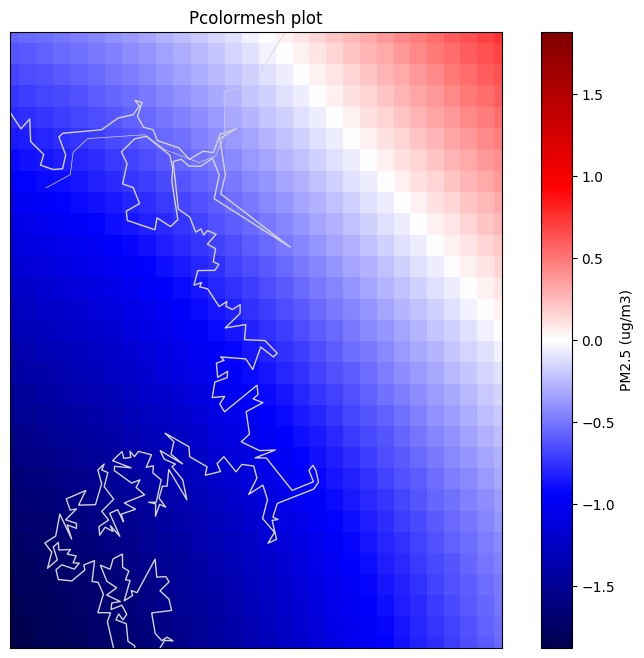

In [ ]:
#Plot data with a seismic colormap.

cm = plt.cm.get_cmap('seismic')
fig = plt.figure(figsize=(10, 8))
m.drawcountries(color='lightgray')
m.drawcoastlines(color='lightgray')
m.pcolormesh(lon,lat, pmfield,latlon=True,cmap=cm) #Pcolormesh plots data as a grid

plt.clim((-1*minmax_val,minmax_val))
plt.title(f'Pcolormesh plot')
plt.colorbar(label='PM2.5 (ug/m3)');


### Imagine that we want to add station data on top of this. We can use the scatter function

<ipython-input-16-e93857b3bdbd>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('seismic')


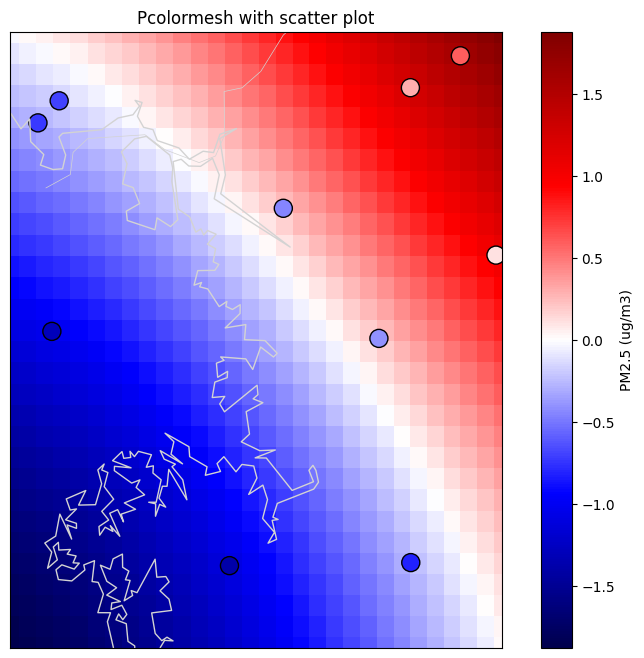

In [ ]:
#Plot data with a seismic colormap.

cm = plt.cm.get_cmap('seismic')
fig = plt.figure(figsize=(10, 8))
m.drawcountries(color='lightgray')
m.drawcoastlines(color='lightgray')

m.pcolormesh(lon,lat, pmfield,latlon=True,cmap=cm) #Pcolormesh plots data as a grid, same as before
m.scatter(stationlon,stationlat,c=stationdata,vmin=-1*minmax_val,vmax=minmax_val,cmap=cm,edgecolors='k',latlon=True,s=169)
plt.clim((-1*minmax_val,minmax_val))
plt.title(f'Pcolormesh with scatter plot')
plt.colorbar(label='PM2.5 (ug/m3)');




## Next, how to make a quick & simple map with `pycno`
`pycno` is good for quickly plotting global maps without much code, but it's less flexible than cartopy or basemap

In [ ]:
import pycno

In [ ]:
# Get global GEOS-Chem data
import xarray as xr
ds = xr.open_dataset('GEOSChem.SpeciesConc.20190701_0000z.nc4')

In [ ]:
ds

<xarray.Dataset>
Dimensions:            (time: 1, lev: 1, lat: 91, lon: 144, ilev: 1, nb: 2)
Coordinates:
  * ilev               (ilev) float64 1.0
  * lat                (lat) float64 -89.5 -88.0 -86.0 -84.0 ... 86.0 88.0 89.5
  * lev                (lev) float64 0.9925
  * lon                (lon) float64 -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * time               (time) datetime64[ns] 2019-07-01
Dimensions without coordinates: nb
Data variables:
    P0                 float64 ...
    SpeciesConcVV_CH4  (time, lev, lat, lon) float32 ...
    hyai               (ilev) float64 ...
    hyam               (lev) float64 ...
    hybi               (ilev) float64 ...
    hybm               (lev) float64 ...
    lat_bnds           (lat, nb) float64 ...
    lon_bnds           (lon, nb) float64 ...
Attributes:
    title:                           GEOS-Chem diagnostic collection: Species...
    history:                         Thu Feb 22 11:27:52 2024: ncks -d time,0...
    format:                          not found
    conventions:                     COARDS
    ProdDateTime:                    
    reference:                       www.geos-chem.org; wiki.geos-chem.org
    contact:                         GEOS-Chem Support Team (geos-chem-suppor...
    simulation_start_date_and_time:  2019-01-01 00:00:00z
    simulation_end_date_and_time:    2020-01-01 00:00:00z
    NCO:                             netCDF Operators version 4.8.1 (Homepage...

In [ ]:
# make map object
cno = pycno.cno(xlim=(ds.lon.min(), ds.lon.max()), ylim=(ds.lat.min(), ds.lat.max()))

/usr/local/lib/python3.10/dist-packages/pycno/__init__.py:187: UserWarning: Path does not exist: /root/.pycno; default .
  warnings.warn('Path does not exist: ' + str(data) + '; default .')


Text(0.5, 1.0, 'surface CH4')

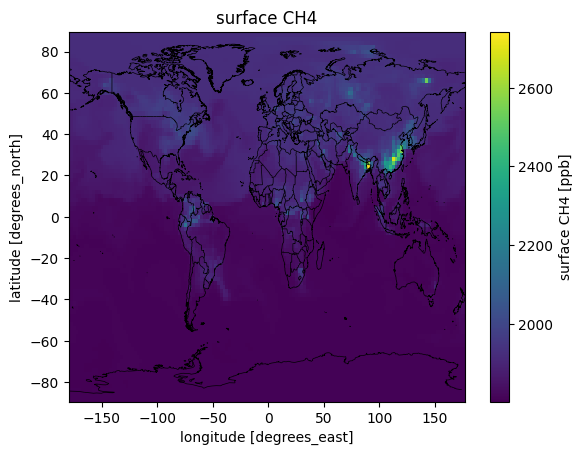

In [ ]:
# plot with pcolormesh
plt.pcolormesh(
    ds.lon, ds.lat,
    ds.SpeciesConcVV_CH4.squeeze() *1e9,
)
cno.draw()
plt.ylabel('latitude [degrees_north]')
plt.xlabel('longitude [degrees_east]')
plt.colorbar(label = 'surface CH4 [ppb]')
plt.title('surface CH4')

## Plot in different projections with `cartopy`
This is more suitable for fancy or complex maps

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Colorbars

matplotlib built in colorbars:  
https://matplotlib.org/stable/users/explain/colors/colormaps.html

More colorbars you can install:  
https://colorcet.holoviz.org/  
https://www.fabiocrameri.ch/colourmaps/




In [ ]:
# plot with pcolormesh
def plot_cmap(cmap):
  plt.pcolormesh(
      ds.lon, ds.lat,
      ds.SpeciesConcVV_CH4.squeeze() *1e9,
      cmap = cmap
  )
  cno.draw()
  plt.ylabel('latitude [degrees_north]')
  plt.xlabel('longitude [degrees_east]')
  plt.title(cmap)
  plt.colorbar(label = 'surface CH4 [ppb]')
  plt.show()

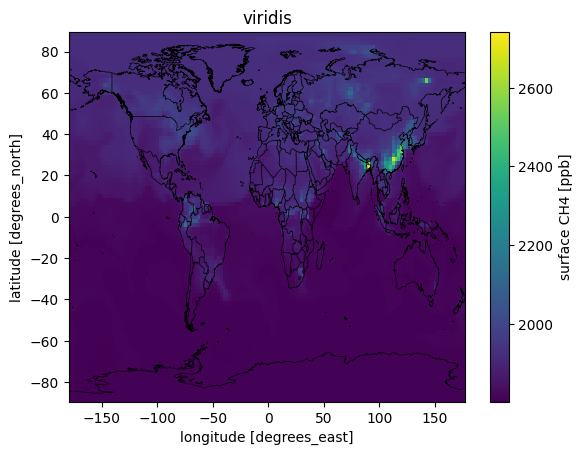

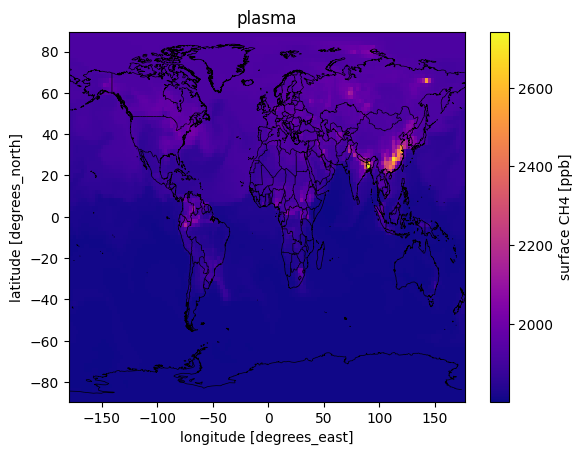

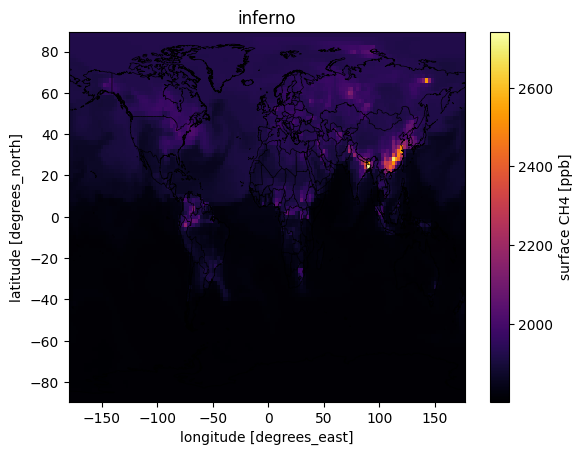

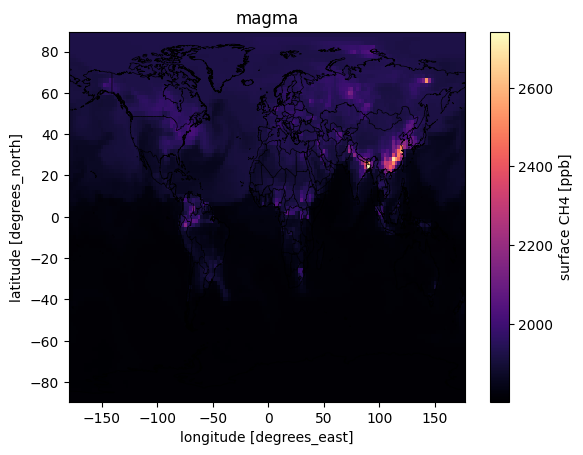

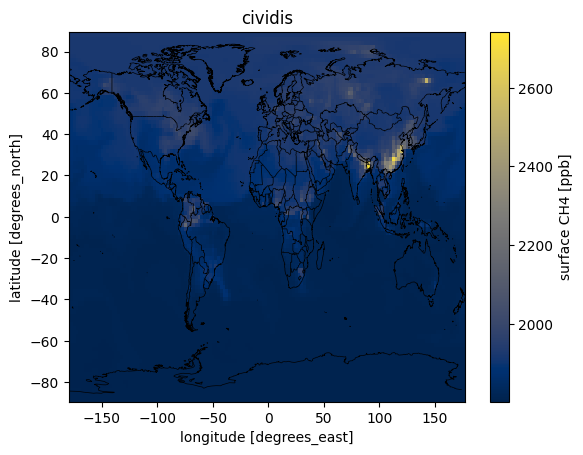

In [ ]:
# perceptually uniform colormaps
for cc in ['viridis', 'plasma', 'inferno', 'magma', 'cividis']:
  plot_cmap(cc)

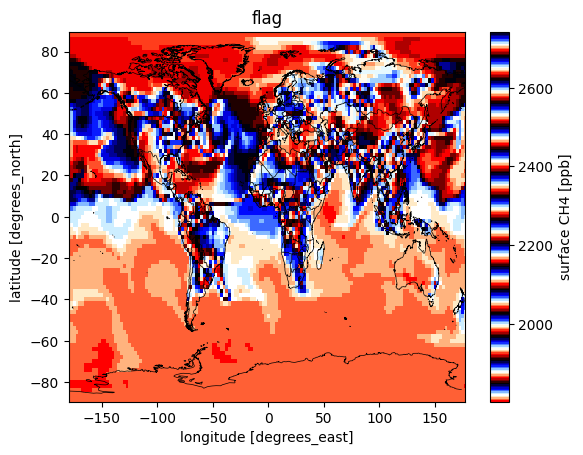

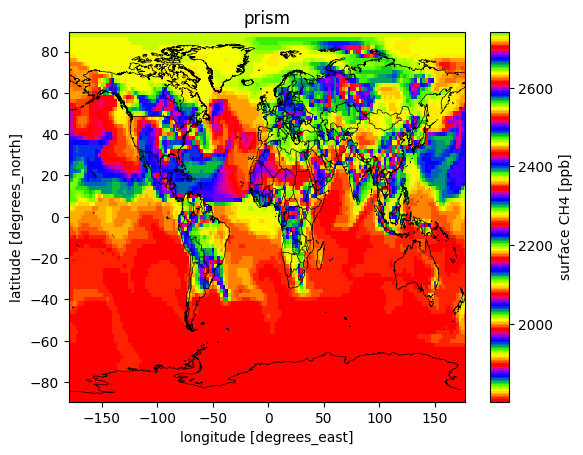

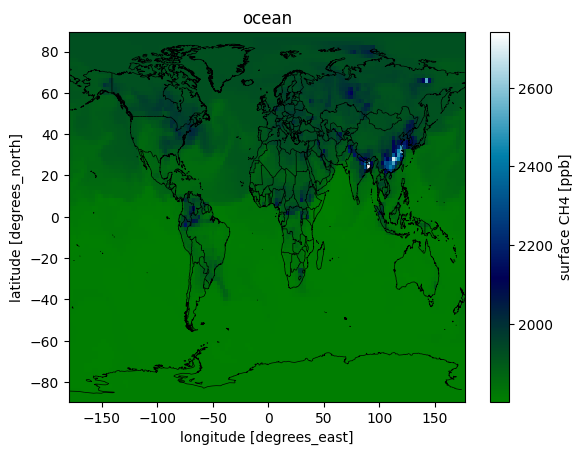

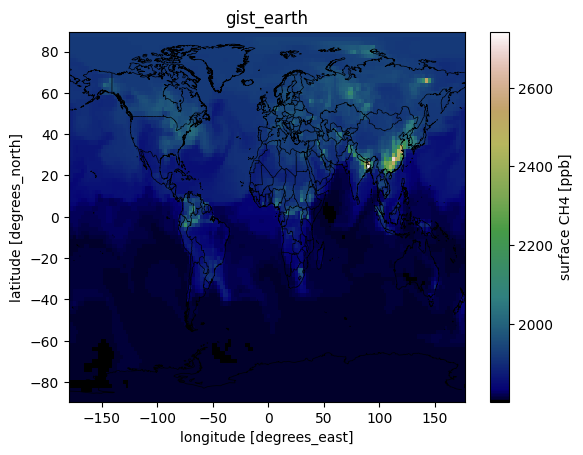

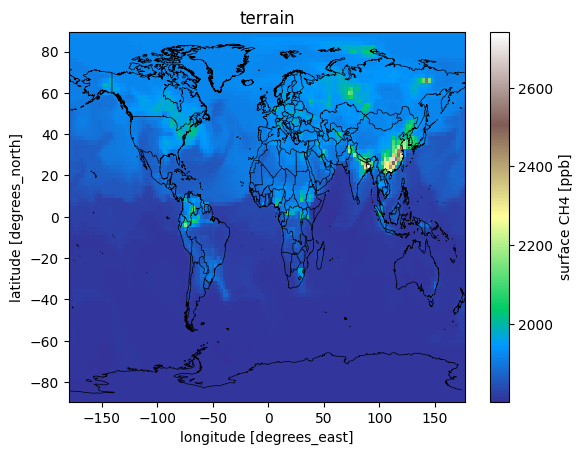

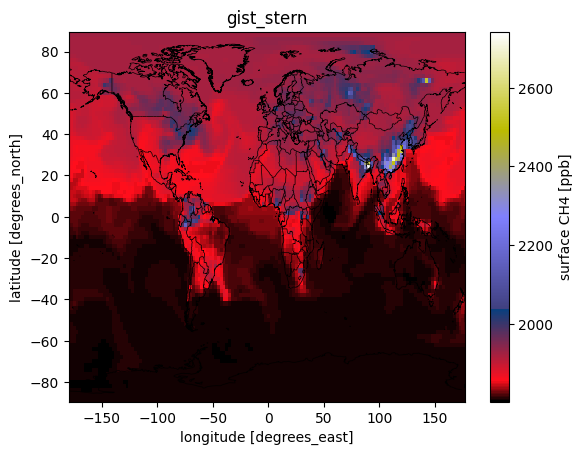

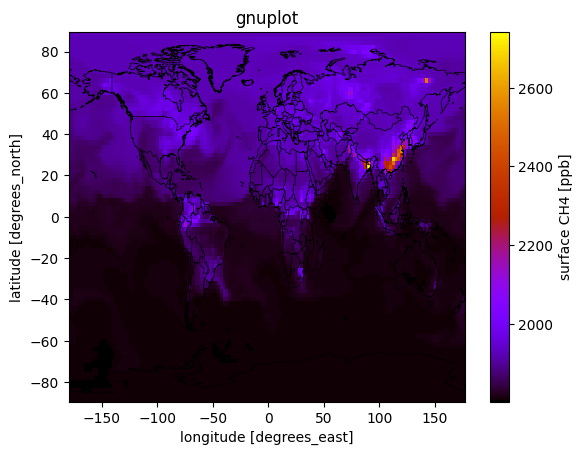

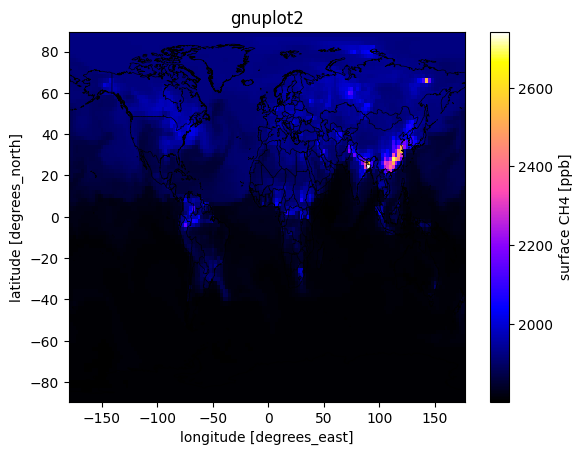

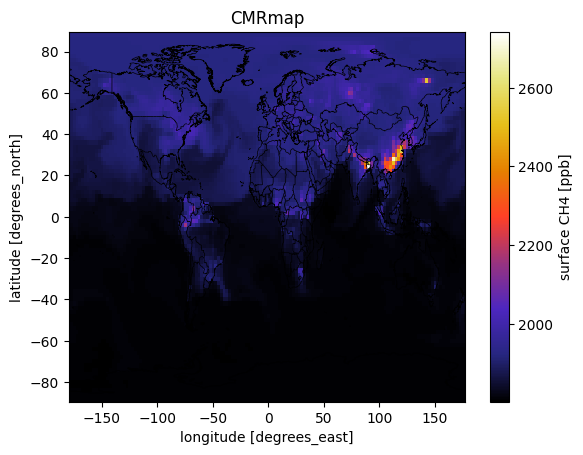

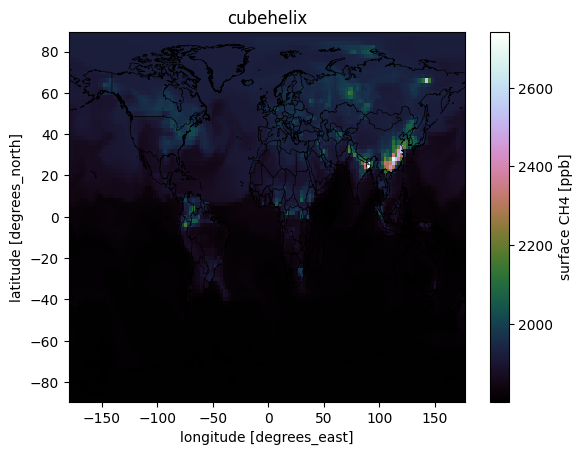

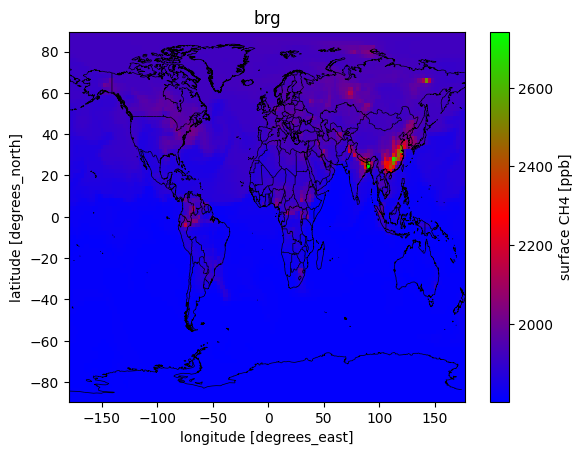

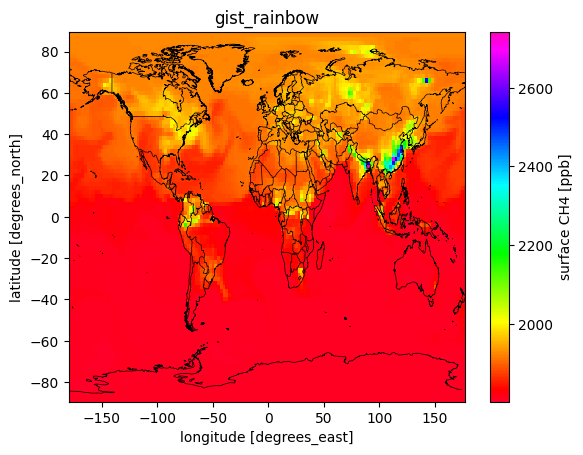

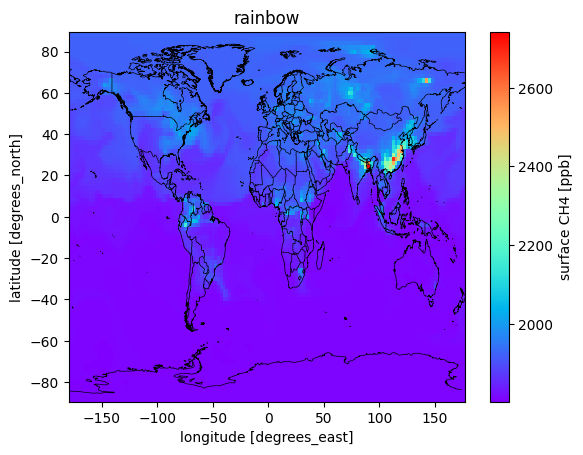

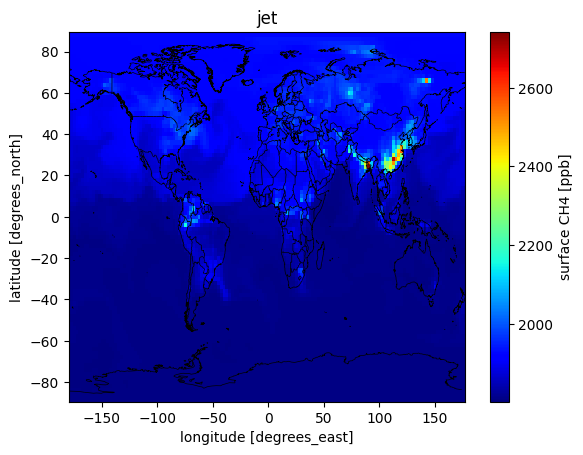

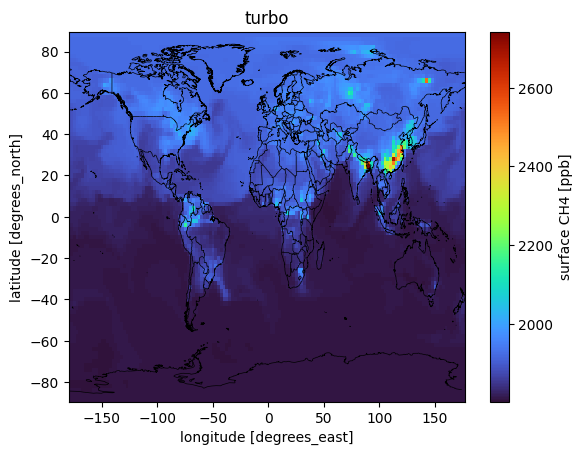

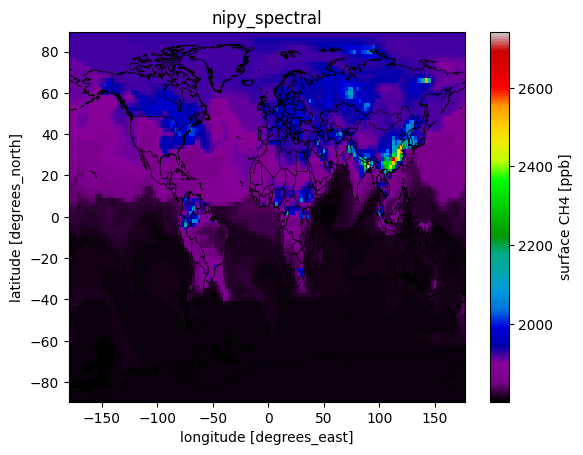

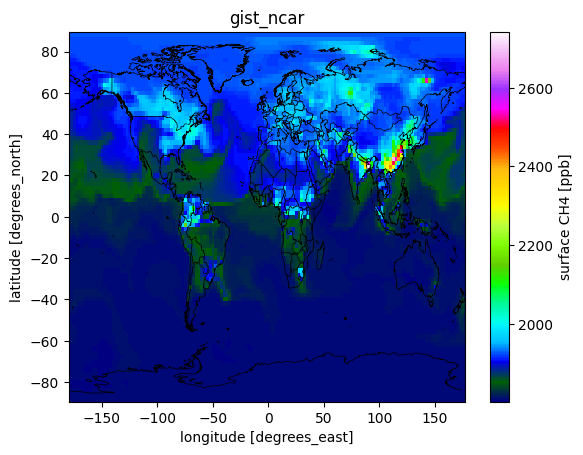

In [ ]:
# jet, rainbow, and more colormaps
other_cmaps = [
  'flag', 'prism', 'ocean', 'gist_earth', 'terrain',
  'gist_stern', 'gnuplot', 'gnuplot2', 'CMRmap',
  'cubehelix', 'brg', 'gist_rainbow', 'rainbow', 'jet',
  'turbo', 'nipy_spectral', 'gist_ncar'
]


for cc in other_cmaps:
  plot_cmap(cc)